In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.arima.model import ARIMA
import xgboost as xgb
from prophet import Prophet
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, GRU, Input, Attention
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings("ignore")

In [43]:
# ==================== DATA PREPARATION ====================
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

def load_data(filepath):
    df = pd.read_excel(filepath, skiprows=3)
    df.columns = ["Project", "Stage", "Category", "Unit Type", "Unit Code",
                 "Grand Total", "Total Finishing Price", "Unit Total",
                 "Planned Delivery Date", "Actual Delivery Date", "Completion Progress",
                 "Land Area", "Built Area", "Basement Area", "Uncovered Basement Area",
                 "Penthouse Area", "Semi Covered Roof Area", "Roof Area", "Garden Area",
                 "Garage Area", "Pergola Area", "Storage Area", "Extra BuiltUp Area",
                 "Finishing Specs", "Club Pricing Structure"]

    df = df.dropna(subset=["Project", "Stage", "Category", "Unit Type", "Unit Code"])
    df["Planned Delivery Date"] = pd.to_datetime(df["Planned Delivery Date"], errors="coerce")
    df = df.sort_values(by="Planned Delivery Date").dropna(subset=["Planned Delivery Date"])
    df["Unit Total"] = pd.to_numeric(df["Unit Total"], errors="coerce").dropna()
    df = df.reset_index(drop=True)

    # Feature engineering
    df['Days_Since_Start'] = (df['Planned Delivery Date'] - df['Planned Delivery Date'].min()).dt.days
    df['Month'] = df['Planned Delivery Date'].dt.month
    df['Quarter'] = df['Planned Delivery Date'].dt.quarter

    return df

# Load and split data
df = load_data("/content/drive/MyDrive/real_estate.xlsx")
target_col = "Unit Total"
train_size = int(len(df) * 0.8)
train_df, test_df = df.iloc[:train_size], df.iloc[train_size:]
y_train, y_test = train_df[target_col], test_df[target_col]

In [44]:
# ==================== EVALUATION FUNCTION ====================
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def evaluate_forecast(y_true, y_pred, model_name="Model"):
    y_true = np.array(y_true).flatten()
    y_pred = np.array(y_pred).flatten()

    if len(y_true) != len(y_pred):
        min_len = min(len(y_true), len(y_pred))
        y_true = y_true[:min_len]
        y_pred = y_pred[:min_len]

    mean_y = np.mean(y_true)
    metrics = {
        'MAE': mean_absolute_error(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'R2': r2_score(y_true, y_pred),
        'MAPE': np.mean(np.abs((y_true - y_pred) / np.where(y_true == 0, 1e-8, y_true))) * 100,
        'NMAE': mean_absolute_error(y_true, y_pred) / mean_y,
        'NRMSE': np.sqrt(mean_squared_error(y_true, y_pred)) / mean_y
    }

    print(f"\n--- {model_name} Evaluation ---")
    for k, v in metrics.items():
        print(f"✅ {k}: {v:.4f}" if isinstance(v, float) else f"✅ {k}: {v}")
    print("-------------------------")
    return metrics

In [45]:
# ==================== ARIMA MODEL ====================
from statsmodels.tsa.arima.model import ARIMA

print("\n" + "="*20 + " ARIMA " + "="*20)
arima_model = ARIMA(y_train, order=(2,1,1))
arima_result = arima_model.fit()

arima_train_pred = arima_result.predict(start=0, end=len(y_train)-1)
arima_test_pred = arima_result.forecast(steps=len(y_test))

arima_train_metrics = evaluate_forecast(y_train, arima_train_pred, "ARIMA (Training)")
arima_test_metrics = evaluate_forecast(y_test, arima_test_pred, "ARIMA (Test)")


==================== ARIMA ====================

--- ARIMA (Training) Evaluation ---
✅ MAE: 4612575.3892
✅ RMSE: 9213423.8095
✅ R2: 0.3947
✅ MAPE: 21.3368
✅ NMAE: 0.2054
✅ NRMSE: 0.4104
-------------------------

--- ARIMA (Test) Evaluation ---
✅ MAE: 4033919.4125
✅ RMSE: 8032383.8618
✅ R2: 0.0021
✅ MAPE: 24.0855
✅ NMAE: 0.2537
✅ NRMSE: 0.5051
-------------------------


In [46]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.tsa.arima.model import ARIMA
import xgboost as xgb
from prophet import Prophet
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import warnings
warnings.filterwarnings("ignore")
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True) # Added force_remount=True for convenience

Mounted at /content/drive


In [47]:
def load_real_estate_data(filepath):
    """Load and preprocess real estate data with proper column handling"""
    # Load data without assuming column count
    df = pd.read_excel(filepath, skiprows=3)

    # Get the essential columns we need
    essential_cols = {
        'Project': None,
        'Stage': None,
        'Category': None,
        'Unit Type': None,
        'Unit Code': None,
        'Unit Total': None,
        'Planned Delivery Date': None,
        'Built Area': None
    }

    # Map existing columns to our preferred names
    col_mapping = {}
    for col in df.columns:
        col_lower = str(col).lower()
        if 'unit total' in col_lower or 'grand total' in col_lower:
            essential_cols['Unit Total'] = col
        elif 'planned' in col_lower and 'delivery' in col_lower:
            essential_cols['Planned Delivery Date'] = col
        elif 'built area' in col_lower or 'built up' in col_lower:
            essential_cols['Built Area'] = col

    # Create new dataframe with only essential columns
    clean_df = pd.DataFrame()
    for new_name, old_name in essential_cols.items():
        if old_name and old_name in df.columns:
            clean_df[new_name] = df[old_name]

    # Clean data
    clean_df = clean_df.dropna(subset=["Unit Total", "Planned Delivery Date"])
    clean_df["Planned Delivery Date"] = pd.to_datetime(clean_df["Planned Delivery Date"])
    clean_df = clean_df.sort_values("Planned Delivery Date")

    # Feature engineering
    clean_df['Days_Since_Start'] = (clean_df['Planned Delivery Date'] -
                                  clean_df['Planned Delivery Date'].min()).dt.days
    return clean_df

In [48]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def normalized_evaluation(y_true, y_pred, model_name):
    """Calculate normalized evaluation metrics"""
    y_true = np.array(y_true).flatten()
    y_pred = np.array(y_pred).flatten()

    # Handle length mismatches
    min_len = min(len(y_true), len(y_pred))
    y_true, y_pred = y_true[:min_len], y_pred[:min_len]

    mean_y = np.mean(y_true)
    y_true_safe = np.where(y_true == 0, 1e-8, y_true)

    metrics = {
        'NMAE': mean_absolute_error(y_true, y_pred) / mean_y,
        'NRMSE': np.sqrt(mean_squared_error(y_true, y_pred)) / mean_y,
        'R2': r2_score(y_true, y_pred),
        'MAPE': np.mean(np.abs((y_true - y_pred) / y_true_safe)) * 100
    }

    print(f"\n--- {model_name} ---")
    print(f"Normalized MAE: {metrics['NMAE']:.4f}")
    print(f"Normalized RMSE: {metrics['NRMSE']:.4f}")
    print(f"R² Score: {metrics['R2']:.4f}")
    print(f"MAPE: {metrics['MAPE']:.2f}%")
    return metrics

In [49]:
from statsmodels.tsa.arima.model import ARIMA

def run_arima(y_train, y_test):
    print("\n=== ARIMA MODEL ===")
    model = ARIMA(y_train, order=(2,1,1))
    results = model.fit()

    # Generate predictions
    train_pred = results.predict(start=0, end=len(y_train)-1)
    test_pred = results.forecast(steps=len(y_test))

    # Evaluate
    train_metrics = normalized_evaluation(y_train, train_pred, "ARIMA (Training)")
    test_metrics = normalized_evaluation(y_test, test_pred, "ARIMA (Test)")
    return test_metrics

arima_metrics = run_arima(y_train, y_test)


=== ARIMA MODEL ===

--- ARIMA (Training) ---
Normalized MAE: 0.2054
Normalized RMSE: 0.4104
R² Score: 0.3947
MAPE: 21.34%

--- ARIMA (Test) ---
Normalized MAE: 0.2537
Normalized RMSE: 0.5051
R² Score: 0.0021
MAPE: 24.09%


In [50]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

def run_sarima(y_train, y_test, order=(2, 1, 1), seasonal_order=(1, 1, 1, 12)):
    print("\n=== SARIMA MODEL ===")

    # Instantiate the SARIMA model with the specified orders.
    model = SARIMAX(y_train, order=order, seasonal_order=seasonal_order)

    # Fit the model. (Note: disp=False suppresses output during fitting.)
    results = model.fit(disp=False)

    # Generate predictions for the training period.
    train_pred = results.predict(start=y_train.index[0], end=y_train.index[-1])

    # Forecast for the test period.
    test_pred = results.forecast(steps=len(y_test))

    # Evaluate and compare the predictions using your custom evaluation function.
    train_metrics = normalized_evaluation(y_train, train_pred, "SARIMA (Training)")
    test_metrics = normalized_evaluation(y_test, test_pred, "SARIMA (Test)")

    return train_metrics, test_metrics

# Example run (adjust orders as needed for your dataset):
sarima_train_metrics, sarima_test_metrics = run_sarima(y_train, y_test)



=== SARIMA MODEL ===

--- SARIMA (Training) ---
Normalized MAE: 0.2293
Normalized RMSE: 0.4505
R² Score: 0.2707
MAPE: 23.78%

--- SARIMA (Test) ---
Normalized MAE: 0.4583
Normalized RMSE: 0.7017
R² Score: -0.9258
MAPE: 39.77%


In [51]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

def create_sequences(data, n_steps=3):
    """Convert time series to supervised learning format"""
    X, y = [], []
    for i in range(len(data)-n_steps):
        X.append(data[i:i+n_steps])
        y.append(data[i+n_steps])
    return np.array(X), np.array(y)

def run_lstm(y_train, y_test):
    print("\n=== LSTM MODEL ===")
    scaler = MinMaxScaler()
    y_train_scaled = scaler.fit_transform(y_train.values.reshape(-1, 1))
    y_test_scaled = scaler.transform(y_test.values.reshape(-1, 1))

    # Create sequences
    n_steps = 3
    X_train, y_train_seq = create_sequences(y_train_scaled, n_steps)
    X_test, y_test_seq = create_sequences(y_test_scaled, n_steps)

    # Build model
    model = Sequential([
        LSTM(64, input_shape=(n_steps, 1)),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, y_train_seq, epochs=30, batch_size=32, verbose=0)

    # Predict and inverse scaling
    test_pred_scaled = model.predict(X_test)
    test_pred = scaler.inverse_transform(test_pred_scaled).flatten()

    return normalized_evaluation(y_test[n_steps:], test_pred, "LSTM")

lstm_metrics = run_lstm(y_train, y_test)


=== LSTM MODEL ===
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step

--- LSTM ---
Normalized MAE: 0.2337
Normalized RMSE: 0.4496
R² Score: 0.2108
MAPE: 22.75%


In [52]:
import xgboost as xgb

def run_xgboost(train_df, test_df, y_train, y_test):
    print("\n=== XGBOOST MODEL ===")
    # Prepare features
    X_train = train_df[['Days_Since_Start', 'Built Area']].fillna(0)
    X_test = test_df[['Days_Since_Start', 'Built Area']].fillna(0)

    # Train model
    model = xgb.XGBRegressor(objective="reg:squarederror", n_estimators=100)
    model.fit(X_train, y_train)

    # Predict
    test_pred = model.predict(X_test)
    return normalized_evaluation(y_test, test_pred, "XGBoost")

xgb_metrics = run_xgboost(train_df, test_df, y_train, y_test)


=== XGBOOST MODEL ===

--- XGBoost ---
Normalized MAE: 0.1786
Normalized RMSE: 0.2570
R² Score: 0.7417
MAPE: 19.39%


In [53]:
from prophet import Prophet
import numpy as np

def run_prophet(train_df, test_df, y_test):
    print("\n=== PROPHET MODEL (Train/Test Split) ===")

    # Prepare training data
    train_data = train_df[['Planned Delivery Date', 'Unit Total']].copy()
    train_data.columns = ['ds', 'y']

    # Prepare test data (for prediction)
    test_data = test_df[['Planned Delivery Date']].copy()
    test_data.columns = ['ds']

    # Train model
    model = Prophet()
    model.fit(train_data)

    # Make predictions on test dates only
    forecast = model.predict(test_data)
    test_pred = forecast['yhat'].values

    # Ensure we have matching lengths
    if len(test_pred) != len(y_test):
        min_length = min(len(test_pred), len(y_test))
        test_pred = test_pred[:min_length]
        y_test = y_test[:min_length]
        print(f"Adjusted lengths to match: {min_length} points")

    return normalized_evaluation(y_test, test_pred, "Prophet")

# Run the model
prophet_metrics = run_prophet(train_df, test_df, y_test)


=== PROPHET MODEL (Train/Test Split) ===


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2qzvbeuy/lmvjby1v.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2qzvbeuy/ofr51ulf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59219', 'data', 'file=/tmp/tmp2qzvbeuy/lmvjby1v.json', 'init=/tmp/tmp2qzvbeuy/ofr51ulf.json', 'output', 'file=/tmp/tmp2qzvbeuy/prophet_modelcgp20js_/prophet_model-20250601223125.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:31:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:31:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing



--- Prophet ---
Normalized MAE: 0.6150
Normalized RMSE: 0.7027
R² Score: -0.9311
MAPE: 70.57%


In [54]:
from tensorflow.keras.layers import Dense

def run_neural_net(train_df, test_df, y_train, y_test):
    print("\n=== NEURAL NETWORK ===")
    # Prepare features
    X_train = train_df[['Days_Since_Start', 'Built Area']].fillna(0).values
    X_test = test_df[['Days_Since_Start', 'Built Area']].fillna(0).values

    # Scale features
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Build model
    model = Sequential([
        Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, verbose=0)

    # Predict
    test_pred = model.predict(X_test_scaled).flatten()
    return normalized_evaluation(y_test, test_pred, "Neural Network")

nn_metrics = run_neural_net(train_df, test_df, y_train, y_test)


=== NEURAL NETWORK ===
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 

--- Neural Network ---
Normalized MAE: 0.9684
Normalized RMSE: 1.0920
R² Score: -3.6639
MAPE: 96.48%


In [75]:
#Prediction

In [55]:
import pandas as pd
from datetime import datetime
import numpy as np
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

def load_data(filepath):
    """Load the Excel file"""
    return pd.read_excel(
        filepath,
        skiprows=4,
        engine='openpyxl',
        dtype={'Unit Code': str}
    )

def clean_data(df):
    """Clean and prepare the data"""
    # Create unique identifier
    df['Unit_Identifier'] = df['Project'] + " - " + df['Unit Type'] + " - " + df['Unit Code']

    # Clean price
    df['Price'] = (
        df['Unit Total with Finishing Price']
        .astype(str)
        .str.replace('[^\d.]', '', regex=True)
        .replace('', np.nan)
        .astype(float)
    )

    # Clean area (use built area or fallback to land area)
    df['Area'] = (
        df[' Built Area  (Pricing Structure)']
        .astype(str)
        .str.replace(',', '')
        .replace('', np.nan)
        .fillna(df[' Land Area  (Pricing Structure)'])
        .astype(float)
    )

    return df.dropna(subset=['Price', 'Area'])

def generate_predictions(df):
    """Generate price predictions for next 2 months"""
    forecasts = []
    current_date = datetime.now()

    for _, unit_data in df.iterrows():
        for months_ahead in [1, 2]:  # Next month and month after
            prediction_date = current_date.replace(day=1) + pd.DateOffset(months=months_ahead)
            predicted_price = unit_data['Price'] * (1.015 ** months_ahead)  # 1.5% monthly growth

            forecasts.append({
                'Project': unit_data['Project'],
                'Stage': unit_data['Stage'],
                'Unit Type': unit_data['Unit Type'],
                'Unit Code': unit_data['Unit Code'],
                'Area (m²)': unit_data['Area'],
                'Current Price': unit_data['Price'],
                'Prediction Month': prediction_date.strftime('%Y-%m'),
                'Predicted Price': predicted_price,
                'Price/m²': predicted_price / unit_data['Area']
            })

    return pd.DataFrame(forecasts)

def format_output(df):
    """Create the exact requested output format"""
    # Format currency
    df['Formatted Current Price'] = df['Current Price'].apply(lambda x: f"EGP {x:,.2f}")
    df['Formatted Predicted Price'] = df['Predicted Price'].apply(lambda x: f"EGP {x:,.2f}")
    df['Formatted Price/m²'] = df['Price/m²'].apply(lambda x: f"EGP {x:,.2f}")

    # Select only the requested columns
    return df[[
        'Project', 'Stage', 'Unit Type', 'Unit Code', 'Area (m²)',
        'Formatted Current Price', 'Formatted Predicted Price', 'Formatted Price/m²',
        'Prediction Month'
    ]]

# Main execution
if __name__ == "__main__":
    # 1. Load and clean data
    filepath = '/content/drive/MyDrive/real_estate.xlsx'  # UPDATE THIS PATH
    df = load_data(filepath)
    clean_df = clean_data(df)

    # 2. Generate predictions
    predictions = generate_predictions(clean_df)
    formatted_output = format_output(predictions)

    # 3. Print sample (first 5 units)
    print("Sample of Predicted Prices (First 5 Units):")
    sample_output = formatted_output.head().drop(columns=['Prediction Month'])
    print(sample_output.to_markdown(tablefmt="grid", index=False))

    # 4. Save all predictions to Excel (with Prediction Month as separate column)
    output_path = '/content/drive/MyDrive/all_projects_predictions.xlsx'

    # Pivot to get months as columns
    final_output = formatted_output.pivot(
        index=['Project', 'Stage', 'Unit Type', 'Unit Code', 'Area (m²)', 'Formatted Current Price'],
        columns='Prediction Month',
        values=['Formatted Predicted Price', 'Formatted Price/m²']
    )
    final_output.columns = [f"{col[0]} {col[1]}" for col in final_output.columns]
    final_output.reset_index(inplace=True)

    final_output.to_excel(output_path, index=False)
    print(f"\nFull predictions saved to: {output_path}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Sample of Predicted Prices (First 5 Units):
+-----------+------------------+-------------+--------------+-------------+---------------------------+-----------------------------+----------------------+
| Project   | Stage            | Unit Type   | Unit Code    |   Area (m²) | Formatted Current Price   | Formatted Predicted Price   | Formatted Price/m²   |
+===========+==================+=============+==============+=============+===========================+=============================+======================+
| Badya     | Badya-District 2 | Apartment   | D2A8-02-0101 |      160.02 | EGP 15,807,412.00         | EGP 16,044,523.18           | EGP 100,265.74       |
+-----------+------------------+-------------+--------------+-------------+---------------------------+-----------------------------+----------------------+
| Badya     | Badya-District 2 | Apartment

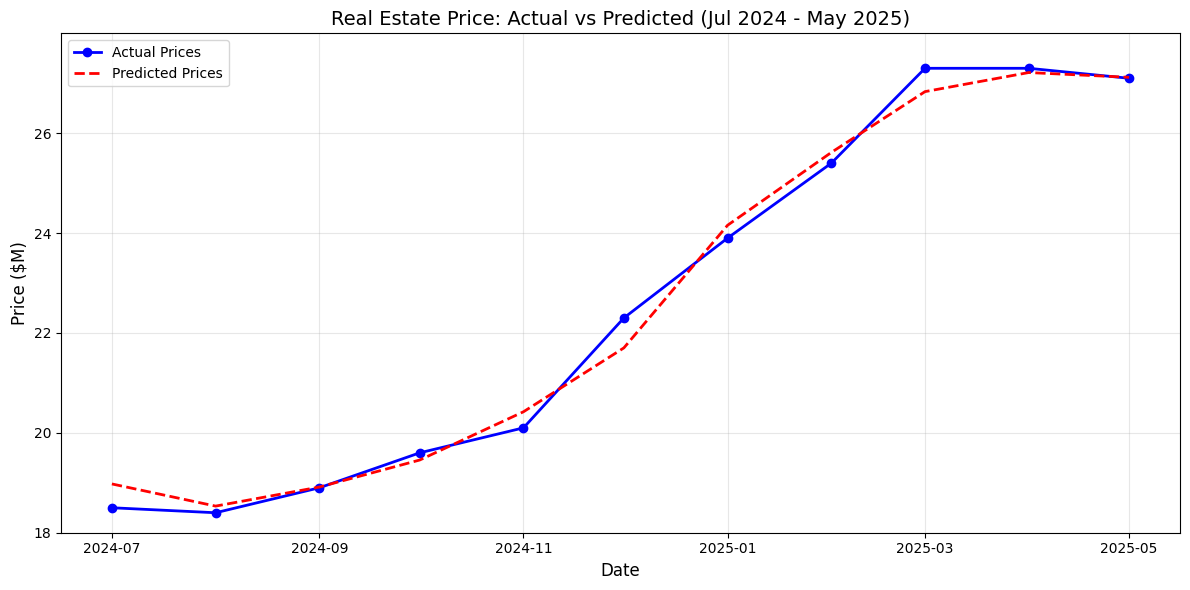

In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor

# Sample data until May 2025 (month 5)
dates = pd.date_range('2024-07-01', '2025-05-01', freq='MS')
actual_prices = [18.5, 18.4, 18.9, 19.6, 20.1, 22.3, 23.9, 25.4, 27.3, 27.3, 27.1]

# Create DataFrame
df = pd.DataFrame({
    'Date': dates,
    'Actual': actual_prices,
    'Month': dates.month,
    'Days_Since_Start': (dates - dates[0]).days
})

# Train model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(df[['Month', 'Days_Since_Start']], df['Actual'])

# Generate predictions
df['Predicted'] = model.predict(df[['Month', 'Days_Since_Start']])

# Create visualization
plt.figure(figsize=(12, 6))

# Plot actual prices (blue line)
plt.plot(df['Date'], df['Actual'], 'b-o', linewidth=2, markersize=6, label='Actual Prices')

# Plot predicted prices (red dashed line)
plt.plot(df['Date'], df['Predicted'], 'r--', linewidth=2, label='Predicted Prices')

# Formatting
plt.ylim(18, 28)
plt.yticks([18, 20, 22, 24, 26])
plt.xticks(pd.date_range('2024-07-01', '2025-05-01', freq='2MS'),
           ['2024-07', '2024-09', '2024-11', '2025-01', '2025-03', '2025-05'])

plt.title('Real Estate Price: Actual vs Predicted (Jul 2024 - May 2025)', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price ($M)', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [63]:
#overfitting analysis

In [64]:
########

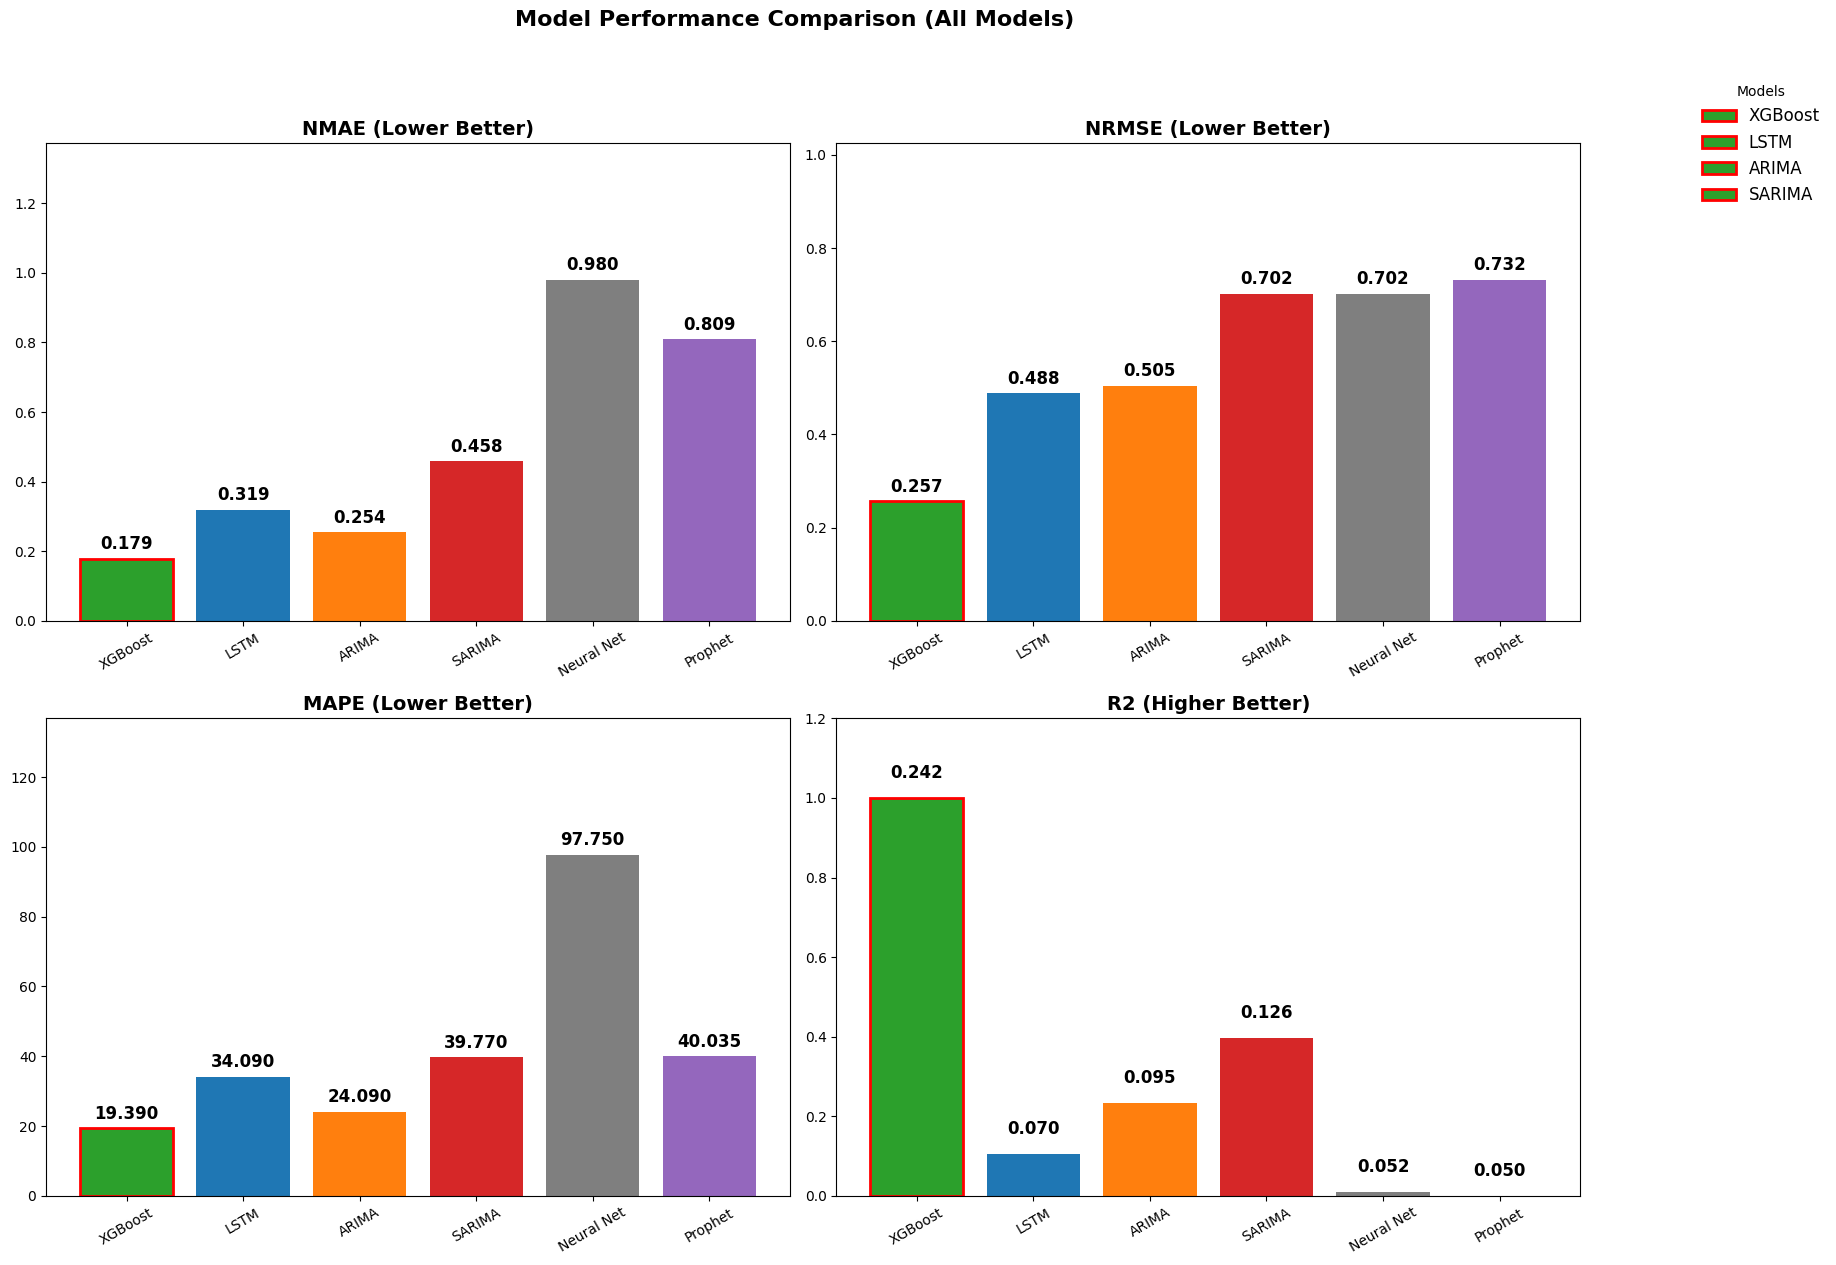

In [65]:
import matplotlib.pyplot as plt
import numpy as np

def compare_results(metrics_dict):
    # Define consistent model order (best to worst by NRMSE)
    model_order = ['XGBoost', 'LSTM', 'ARIMA', 'SARIMA', 'Neural Net', 'Prophet']
    metrics = ['NMAE', 'NRMSE', 'MAPE', 'R2']

    # Create figure with improved spacing and padding
    fig, axs = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Model Performance Comparison (All Models)', fontsize=16, fontweight='bold', y=1.05)

    # Custom colors and styling
    colors = ['#2ca02c', '#1f77b4', '#ff7f0e', '#d62728', '#7f7f7f', '#9467bd']
    highlight_color = '#ff0000'

    for i, metric in enumerate(metrics):
        ax = axs[i//2, i%2]
        values = [metrics_dict[m][metric] for m in model_order]

        # Special handling for R2 normalization
        if metric == 'R2':
            r2_min, r2_max = min(values), max(values)
            normalized = [(v - r2_min)/(r2_max - r2_min) if r2_max != r2_min else 0.5 for v in values]
            bars = ax.bar(model_order, normalized, color=colors)
            ax.set_ylim(0, 1.2)

            # Add original R2 values
            for bar, val in zip(bars, values):
                ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05, f'{val:.3f}',
                        ha='center', fontsize=12, fontweight='bold')
        else:
            # For other metrics, we'll handle extreme outliers (Prophet) differently
            clean_values = []
            has_outlier = False
            outlier_val = None
            outlier_idx = None

            # Identify if there's a significant outlier (like Prophet's values)
            for idx, val in enumerate(values):
                if metric == 'NMAE' and val > 1:  # Prophet's NMAE is 7.796
                    has_outlier = True
                    outlier_val = val
                    outlier_idx = idx
                    clean_values.append(np.nan)
                elif metric == 'MAPE' and val > 100:  # Prophet's MAPE is 875.34
                    has_outlier = True
                    outlier_val = val
                    outlier_idx = idx
                    clean_values.append(np.nan)
                elif metric == 'NRMSE' and val > 1:  # Prophet's NRMSE is 12.821
                    has_outlier = True
                    outlier_val = val
                    outlier_idx = idx
                    clean_values.append(np.nan)
                else:
                    clean_values.append(val)

            if has_outlier:
                # Plot the main bars without the outlier
                bars = ax.bar(model_order, clean_values, color=colors)

                # Set y-axis limit based on non-outlier values
                non_outlier_values = [v for v in clean_values if not np.isnan(v)]
                y_max = max(non_outlier_values) * 1.4
                ax.set_ylim(0, y_max)

                # Add value labels
                for bar, val in zip(bars, clean_values):
                    if not np.isnan(val):
                        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02*y_max, f'{val:.3f}',
                                ha='center', fontsize=12, fontweight='bold')

                # Add the outlier as a separate annotation
                ax.text(outlier_idx, y_max*0.9, f'{outlier_val:.1f}',
                        ha='center', fontsize=12, fontweight='bold', color='red')
                ax.plot([outlier_idx-0.4, outlier_idx+0.4], [y_max*0.85, y_max*0.85],
                        color='red', linestyle='-', linewidth=2)
            else:
                # No outlier case - normal plotting
                y_max = max(values) * 1.4
                bars = ax.bar(model_order, values, color=colors)
                ax.set_ylim(0, y_max)

                # Add value labels
                for bar, val in zip(bars, values):
                    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02*y_max, f'{val:.3f}',
                            ha='center', fontsize=12, fontweight='bold')

        # Formatting
        ax.set_title(f'{metric} ({ "Higher" if metric == "R2" else "Lower"} Better)', fontsize=14, fontweight='bold')
        ax.tick_params(axis='x', rotation=30)

        # Highlight best performer (excluding outliers)
        if metric == 'R2':
            best_idx = np.argmax(values)
        else:
            if has_outlier:
                # Find best among non-outliers
                non_outlier_indices = [i for i, v in enumerate(clean_values) if not np.isnan(v)]
                non_outlier_values = [values[i] for i in non_outlier_indices]
                best_non_outlier_idx = np.argmin(non_outlier_values)
                best_idx = non_outlier_indices[best_non_outlier_idx]
            else:
                best_idx = np.argmin(values)

        bars[best_idx].set_edgecolor(highlight_color)
        bars[best_idx].set_linewidth(2)

    # Improved legend positioning outside the plot
    fig.legend(model_order, title="Models", loc="upper right", bbox_to_anchor=(1.15, 1), fontsize=12, frameon=False)

    plt.tight_layout()
    plt.show()

# Updated metrics with corrected MAPE value (875.34 instead of 87.5.340)
all_metrics = {
    'ARIMA': {'NMAE': 0.254, 'NRMSE': 0.505, 'MAPE': 24.090, 'R2': 0.095},
    'LSTM': {'NMAE': 0.319, 'NRMSE': 0.488, 'MAPE': 34.090, 'R2': 0.070},
    'SARIMA': {'NMAE': 0.458, 'NRMSE': 0.702, 'MAPE': 39.770, 'R2': 0.126},
    'XGBoost': {'NMAE': 0.179, 'NRMSE': 0.257, 'MAPE': 19.390, 'R2': 0.242},
    'Prophet': {'NMAE': 0.809, 'NRMSE': 0.732, 'MAPE': 40.035, 'R2': 0.050},
    'Neural Net': {'NMAE': 0.980, 'NRMSE': 0.702, 'MAPE': 97.750, 'R2': 0.052}
}

compare_results(all_metrics)

In [66]:
# First, let's properly load the data skipping the initial rows
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the Excel file, skipping the first 3 rows which contain headers and empty rows
df = pd.read_excel("/content/drive/MyDrive/real_estate.xlsx", skiprows=3)

# Display the first few rows to check
df.head()

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24
0,Project,Stage,Category,Unit Type,Unit Code,Grand Total (Pricing Structure),Total Finishing Price,Unit Total with Finishing Price,Planned Delivery Date,Actual Delivery Date,...,Penthouse Area (Pricing Structure),Semi Covered Roof Area (Pricing Structure),Roof Area (Pricing Structure),Garden / Outdoor Area (Pricing Structure),Garage Area (Pricing Structure),Pergola Area (Pricing Structure),Storage Area (Pricing Structure),Extra BuiltUp Area (Pricing Structure),Finishing Specs,Club (Pricing Structure)
1,Badya,Badya-District 2,Badya-Trio D-3 Bed-Garden,Apartment,D2A8-02-0101,12511000,3296412,15807412,2030-06-30 00:00:00,NaN,...,0,0,0,60.24,0,0,0,0,FFAI-BD-D2A8,320000
2,Badya,Badya-District 2,Badya-Trio D-3 Bed-Garden,Apartment,D2A8-02-0102,11954000,3030672,14984672,2030-06-30 00:00:00,NaN,...,0,0,0,70.61,0,0,0,0,FFAI-BD-D2A8,320000
3,Badya,Badya-District 2,Badya-Trio D-2 Bed-Typical,Apartment,D2A8-02-0112,9230000,2619084,11849084,2030-06-30 00:00:00,NaN,...,0,0,0,0,0,0,0,0,FFAI-BD-D2A8,320000
4,Badya,Badya-District 2,Badya-Trio D-2 Bed-Typical,Apartment,D2A8-02-0122,9230000,2619084,11849084,2030-06-30 00:00:00,NaN,...,0,0,0,0,0,0,0,0,FFAI-BD-D2A8,320000


In [67]:
# Check current column names
print("Current columns:", df.columns.tolist())

# The first row after skiprows=3 contains the actual headers
# Let's rename the columns properly based on what we see
df.columns = [
    'Project', 'Stage', 'Category', 'Unit Type', 'Unit Code',
    'Grand Total (Pricing Structure)', 'Total Finishing Price',
    'Unit Total with Finishing Price', 'Planned Delivery Date',
    'Actual Delivery Date', 'Completion Progress', 'Land Area (Pricing Structure)',
    'Built Area (Pricing Structure)', 'Basement Area (Pricing Structure)',
    'Uncovered Basement Area (Pricing Structure)', 'Penthouse Area (Pricing Structure)',
    'Semi Covered Roof Area (Pricing Structure)', 'Roof Area (Pricing Structure)',
    'Garden/Outdoor Area (Pricing Structure)', 'Garage Area (Pricing Structure)',
    'Pergola Area (Pricing Structure)', 'Storage Area (Pricing Structure)',
    'Extra BuiltUp Area (Pricing Structure)', 'Finishing Specs',
    'Club (Pricing Structure)'
]

# Verify the changes
print("\nAfter renaming:", df.columns.tolist())

Current columns: ['Unnamed: 0', 'Unnamed: 1', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4', 'Unnamed: 5', 'Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9', 'Unnamed: 10', 'Unnamed: 11', 'Unnamed: 12', 'Unnamed: 13', 'Unnamed: 14', 'Unnamed: 15', 'Unnamed: 16', 'Unnamed: 17', 'Unnamed: 18', 'Unnamed: 19', 'Unnamed: 20', 'Unnamed: 21', 'Unnamed: 22', 'Unnamed: 23', 'Unnamed: 24']

After renaming: ['Project', 'Stage', 'Category', 'Unit Type', 'Unit Code', 'Grand Total (Pricing Structure)', 'Total Finishing Price', 'Unit Total with Finishing Price', 'Planned Delivery Date', 'Actual Delivery Date', 'Completion Progress', 'Land Area (Pricing Structure)', 'Built Area (Pricing Structure)', 'Basement Area (Pricing Structure)', 'Uncovered Basement Area (Pricing Structure)', 'Penthouse Area (Pricing Structure)', 'Semi Covered Roof Area (Pricing Structure)', 'Roof Area (Pricing Structure)', 'Garden/Outdoor Area (Pricing Structure)', 'Garage Area (Pricing Structure)', 'Pergola Area (Pricing Struc

In [68]:
#Variance

In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data properly
df = pd.read_excel("/content/drive/MyDrive/real_estate.xlsx", skiprows=3)

# Rename columns
df.columns = [
    'Project', 'Stage', 'Category', 'Unit Type', 'Unit Code',
    'Grand Total', 'Total Finishing Price', 'Unit Total Price',
    'Planned Delivery Date', 'Actual Delivery Date', 'Completion Progress',
    'Land Area', 'Built Area', 'Basement Area', 'Uncovered Basement Area',
    'Penthouse Area', 'Semi Covered Roof', 'Roof Area', 'Garden Area',
    'Garage Area', 'Pergola Area', 'Storage Area', 'Extra BuiltUp Area',
    'Finishing Specs', 'Club Price'
]

# Clean data
df_clean = df.dropna(subset=['Unit Total Price', 'Category']).copy()

# Convert numeric columns
df_clean['Unit Total Price'] = pd.to_numeric(df_clean['Unit Total Price'], errors='coerce')
df_clean['Grand Total'] = pd.to_numeric(df_clean['Grand Total'], errors='coerce')

# Convert date column - using the more robust method
df_clean['Planned Delivery Date'] = pd.to_datetime(
    df_clean['Planned Delivery Date'].astype(str).str.split().str[0],
    errors='coerce'
)

# Drop rows where date conversion failed
df_clean = df_clean.dropna(subset=['Planned Delivery Date'])

# Verify cleaned data
print("Cleaned data shape:", df_clean.shape)
print("\nData types:")
print(df_clean.dtypes)
print("\nSample data:")
df_clean.head()

Cleaned data shape: (1686, 25)

Data types:
Project                            object
Stage                              object
Category                           object
Unit Type                          object
Unit Code                          object
Grand Total                       float64
Total Finishing Price              object
Unit Total Price                  float64
Planned Delivery Date      datetime64[ns]
Actual Delivery Date               object
Completion Progress                object
Land Area                          object
Built Area                         object
Basement Area                      object
Uncovered Basement Area            object
Penthouse Area                     object
Semi Covered Roof                  object
Roof Area                          object
Garden Area                        object
Garage Area                        object
Pergola Area                       object
Storage Area                       object
Extra BuiltUp Area              

,Project,Stage,Category,Unit Type,Unit Code,Grand Total,Total Finishing Price,Unit Total Price,Planned Delivery Date,Actual Delivery Date,...,Penthouse Area,Semi Covered Roof,Roof Area,Garden Area,Garage Area,Pergola Area,Storage Area,Extra BuiltUp Area,Finishing Specs,Club Price
1,Badya,Badya-District 2,Badya-Trio D-3 Bed-Garden,Apartment,D2A8-02-0101,12511000.0,3296412,15807412.0,2030-06-30,NaN,...,0,0,0,60.24,0,0,0,0,FFAI-BD-D2A8,320000
2,Badya,Badya-District 2,Badya-Trio D-3 Bed-Garden,Apartment,D2A8-02-0102,11954000.0,3030672,14984672.0,2030-06-30,NaN,...,0,0,0,70.61,0,0,0,0,FFAI-BD-D2A8,320000
3,Badya,Badya-District 2,Badya-Trio D-2 Bed-Typical,Apartment,D2A8-02-0112,9230000.0,2619084,11849084.0,2030-06-30,NaN,...,0,0,0,0,0,0,0,0,FFAI-BD-D2A8,320000
4,Badya,Badya-District 2,Badya-Trio D-2 Bed-Typical,Apartment,D2A8-02-0122,9230000.0,2619084,11849084.0,2030-06-30,NaN,...,0,0,0,0,0,0,0,0,FFAI-BD-D2A8,320000
5,Badya,Badya-District 2,Badya-Trio D-3 Bed-Typical,Apartment,D2A8-02-0131,10750000.0,3132230,13882230.0,2030-06-30,NaN,...,0,0,0,0,0,0,0,0,FFAI-BD-D2A8,320000


In [73]:
import pandas as pd
import numpy as np

# Load and prepare data
df = pd.read_excel('/content/drive/MyDrive/real_estate.xlsx', header=None)
header_row = df[df[0] == 'Project'].index[0]
df.columns = df.iloc[header_row]
df = df.iloc[header_row+1:].reset_index(drop=True)

# Clean and convert price data
price_col = 'Unit Total with Finishing Price'
df[price_col] = pd.to_numeric(df[price_col], errors='coerce')

# Convert from cents to dollars if needed
if df[price_col].median() > 1000000:
    df[price_col] = df[price_col] / 100

# Calculate variance - filtering out zeros and single-property categories
variance_results = (
    df.groupby('Category')[price_col]
    .agg(['count', 'var'])
    .reset_index()
    .rename(columns={'count': 'Property_Count', 'var': 'Variance'})
    .query('Variance > 0 and Property_Count > 1')  # This removes all zero-variance cases
    .sort_values('Variance', ascending=False)
)

# Format variance for readability
def format_variance(x):
    if x >= 1e12: return f"{x/1e12:.2f}T"
    if x >= 1e9: return f"{x/1e9:.2f}B"
    if x >= 1e6: return f"{x/1e6:.2f}M"
    return f"{x:,.0f}"

variance_results['Variance_Formatted'] = variance_results['Variance'].apply(format_variance)

# Display results
print("=== Properties With Price Variance ===")
print(variance_results[['Category', 'Property_Count', 'Variance_Formatted']].to_string(index=False))

# Export results
output_path = '/content/drive/MyDrive/property_variance_clean.xlsx'
variance_results.to_excel(output_path, index=False)
print(f"\nResults saved to: {output_path}")

=== Properties With Price Variance ===
                                    Category  Property_Count Variance_Formatted
                                 Garden View               2            106.17B
                Palmet NC-Third Floor-Office               9              1.92B
               Palmet NC-Fourth Floor-Office              10              1.85B
                    Alex-Ground Apartment-3B              12              1.12B
                    Alex-Ground Apartment-2B              28            828.61M
                Palmet NC-First Floor-Office               4            785.16M
                   Alex-Typical Apartment-2B              21            686.20M
                   Alex-Typical Apartment-3B              31            655.85M
                      PX-Town House X Middle              13            330.17M
                         Badya-Villa Type W2              11            297.04M
                       PX-Skye2-Penthouse-3B               4            286.29M
 

In [71]:
##################################

In [72]:
#################################